In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import pickle
import torch
import io
import random
from gensim.models import Word2Vec

In [2]:
sns.__version__

'0.11.0'

In [3]:
# function to work around loading a GPU generated pickle on local CPU machine
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [4]:
# load synthesizer from saved object
with open('models/TVAE_synthesizer_10emb_noCat_ageCat70_0.1M.pkl', 'rb') as input:
    synthesizer = CPU_Unpickler(input).load()

# modify device from cuda:0 to cpu
synthesizer.device = 'cpu'

In [5]:
# load synthesizer from local machine
#with open('models/TVAE_synthesizer_test.pkl', 'rb') as input:
#    synthesizer = pickle.load(input)

In [6]:
# check out sample
N = 100000
sample = synthesizer.sample(N)
np.set_printoptions(suppress = True, precision = 2)

In [7]:
df_input = pd.read_csv('data/cc_data_input_10emb_ageCat70.csv')

In [8]:
input_columns = list(df_input.columns)[1:]

In [9]:
df_sample = pd.DataFrame(sample, columns=input_columns) 
pd.set_option('display.max_columns', 45)
df_sample.head()

,Purchase Amount,Account Type_bank_account,Account Type_credit_card,Consumer Gender_female,Consumer Gender_male,SIC Description_Book Stores,"SIC Description_Communications Services, Not Elsewhere Classified",SIC Description_Drug Stores and Proprietary Stores,SIC Description_Eating Places,SIC Description_Family Clothing Stores,SIC Description_Gasoline Service Stations,SIC Description_Grocery Stores,SIC Description_Miscellaneous Food Stores,SIC Description_Other,SIC Description_Taxicabs,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,period_of_month_end,period_of_month_mid,period_of_month_start,"Age Range_(20, 25]","Age Range_(25, 30]","Age Range_(30, 35]","Age Range_(35, 40]","Age Range_(40, 45]","Age Range_(45, 50]","Age Range_(50, 55]","Age Range_(55, 60]","Age Range_(60, 65]","Age Range_(65, 70]",retailerVec_01,retailerVec_02,retailerVec_03,retailerVec_04,retailerVec_05,retailerVec_06,retailerVec_07,retailerVec_08,retailerVec_09,retailerVec_10
0,2.226615,0.000516,0.999960,0.000023,1.000128,-0.000045,-0.000092,0.000013,0.000055,0.000031,-0.000002,0.999990,0.000014,0.000035,-0.000012,0.000122,0.000037,-0.000003,-0.000010,0.000114,-0.000020,0.000084,-0.000154,-0.000142,0.000063,-0.000005,0.000122,-0.000011,9.809890e-05,-0.000007,0.000002,0.000014,0.000038,-0.000006,0.000076,0.391167,-1.798462,-1.496645,0.442966,-0.497977,-2.377977,-1.109803,-0.413073,-0.865091,-0.464055
1,67.918915,0.000207,1.000216,0.000009,1.000026,0.000103,-0.000059,0.000003,0.000122,-0.000022,1.000081,0.000021,0.000041,-0.000128,0.000023,0.000062,-0.000163,0.000009,0.000100,-0.000021,0.000060,0.000048,0.000176,0.000022,0.000088,0.000007,-0.000090,0.000016,-2.111845e-05,0.000097,0.000040,-0.000079,0.000053,-0.000061,-0.000021,1.608621,-0.437478,-0.515879,1.840318,-0.617836,-1.921718,0.576286,-2.588943,-2.236481,-0.086691
2,5.661695,-0.000022,0.999985,1.000232,0.000041,0.000027,-0.000033,1.000549,-0.000085,0.000042,-0.000035,-0.000045,-0.000004,0.000079,-0.000072,-0.000049,0.000006,-0.000077,-0.000012,0.000056,0.000008,0.000055,-0.000052,-0.000033,-0.000056,0.000007,0.000022,0.000100,-1.409624e-05,-0.000015,-0.000105,0.000051,0.000047,0.000015,0.000068,1.229196,-1.248858,-1.508481,1.274489,-2.544328,-2.617532,-0.440031,-2.478213,-1.807626,0.071633
3,0.245680,0.999864,0.000047,1.000039,0.000006,-0.000063,0.000018,0.000027,1.000265,-0.000046,-0.000211,-0.000038,-0.000051,-0.000134,-0.000030,0.000096,0.000021,0.000134,-0.000022,-0.000199,0.000016,0.000106,-0.000084,0.000091,-0.000025,0.000048,-0.000088,-0.000003,5.698951e-06,-0.000051,0.000057,-0.000086,0.000059,-0.000020,0.000011,0.172080,-1.144024,0.397283,0.338375,-0.653426,-0.267543,-0.852832,-0.685917,-0.485890,0.500183
4,4.567486,1.000047,0.000050,-0.000050,0.999975,0.000089,-0.000040,-0.000038,-0.000005,-0.000048,0.000014,0.000005,0.000133,0.000105,-0.000013,-0.000092,0.000059,0.000030,-0.000012,0.000078,0.000046,0.000076,0.000069,-0.000045,-0.000073,-0.000049,-0.000017,0.000011,-2.583914e-08,-0.000046,-0.000041,-0.000002,-0.000108,0.000078,0.000015,0.861509,-0.475126,-1.163700,2.052316,1.278406,-1.022824,-0.538515,-0.089113,-1.583078,1.615250


In [10]:
# return series of dummy variables with given column name
def reverse_dummy(df, col_name):
    # get index of columns that starts with col_name, for example, Gender_male, Gender_female for col_name = `Gender`
    idx = [i for i, s in enumerate(list(df.columns)) if col_name in s]
    tmp = df.iloc[:,idx]
    # find column name for absolute max in each row and put into one series
    df_output = pd.Series(tmp.abs().idxmax(axis=1), name = col_name)
    
    # remove strings with col_name plus underscore
    df_output = df_output.map(lambda x: x.replace(col_name + '_',''))
    return df_output

In [11]:
#df_purchase = df_sample.iloc[:,[0,1]]
df_purchase = df_sample.iloc[:,[0]]
df_age = reverse_dummy(df_sample,'Age Range')
df_account = reverse_dummy(df_sample,'Account Type')
df_gender = reverse_dummy(df_sample,'Consumer Gender')
df_SIC = reverse_dummy(df_sample,'SIC Description')
df_dw = reverse_dummy(df_sample,'day_of_week')
df_pm = reverse_dummy(df_sample,'period_of_month')

In [12]:
#df_reverse = pd.concat([df_purchase,df_account,df_gender,df_SIC,df_dw,df_pm], axis=1)
df_reverse = pd.concat([df_purchase,df_age,df_account,df_gender,df_SIC,df_dw,df_pm], axis=1)

# remove negative purchase amount
df_reverse = df_reverse[(df_reverse['Purchase Amount'] > 0)]
df_reverse.reset_index(drop=True, inplace=True)

#pd.set_option('display.max_rows', N)
print(df_reverse.shape)
df_reverse.head()

(97020, 7)


,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month
0,2.226615,"(25, 30]",credit_card,male,Grocery Stores,Friday,end
1,67.918915,"(40, 45]",credit_card,male,Gasoline Service Stations,Monday,end
2,5.661695,"(45, 50]",credit_card,female,Drug Stores and Proprietary Stores,Saturday,start
3,0.245680,"(25, 30]",bank_account,female,Eating Places,Thursday,mid
4,4.567486,"(55, 60]",bank_account,male,Miscellaneous Food Stores,Friday,start


In [13]:
def return_age(age_range):
    age_range = age_range.replace('(','').replace(']','').replace(' ','')
    r1 = int(age_range.split(',')[0])
    r2 = int(age_range.split(',')[1])
    return random.choice(list(range(r1+1, r2+1)))

In [14]:
df_reverse['Age'] = df_reverse.apply(lambda x: return_age(x['Age Range']), axis = 1)
df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age
0,2.226615,"(25, 30]",credit_card,male,Grocery Stores,Friday,end,26
1,67.918915,"(40, 45]",credit_card,male,Gasoline Service Stations,Monday,end,43
2,5.661695,"(45, 50]",credit_card,female,Drug Stores and Proprietary Stores,Saturday,start,46
3,0.245680,"(25, 30]",bank_account,female,Eating Places,Thursday,mid,27
4,4.567486,"(55, 60]",bank_account,male,Miscellaneous Food Stores,Friday,start,59


In [15]:
#df_reverse['SIC Description'].value_counts().index.to_list()

In [16]:
# reverse retailerVec back to retailers
idx = [i for i, s in enumerate(list(df_sample.columns)) if 'retailerVec' in s]
df_retailerVec = df_sample.iloc[:,idx]

# load the retailer_map
with open('models/retailer_map.pkl', 'rb') as input:
    retailer_map = pickle.load(input)    

model = Word2Vec.load('models/perSICperPerson_10emb.model')
    
# only keep values in the model (more than 5 times appearance)
for key, value in retailer_map.items():
    retailer_map[key] = list(set(value) & set(model.wv.vocab))
    
# group other SIC (after top N) into other
list2keep = ['Eating Places', 'Grocery Stores', 'Gasoline Service Stations', 'Book Stores', 'Drug Stores and Proprietary Stores', 'Miscellaneous Food Stores', 'Family Clothing Stores', 'Taxicabs', 'Communications Services, Not Elsewhere Classified']
other_list = []    
for key, value in retailer_map.items():
    if key not in list2keep:
        other_list = other_list + value

# delete other group key-values in retailer_map
retailer_map_grouped = {k: retailer_map[k] for k in list2keep}

# add other key-value pairs
retailer_map_grouped['Other'] = other_list

# put retailer vectors into one column
df_retailerVec['retailerVec']= df_retailerVec.values.tolist()
df_SIC_vector = pd.concat([df_SIC,df_retailerVec['retailerVec']],axis = 1)
df_SIC_vector.head()

d:\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SIC Description,retailerVec
0,Grocery Stores,"[0.3911672238183825, -1.7984622181401715, -1.4..."
1,Gasoline Service Stations,"[1.608620787705154, -0.43747778539614435, -0.5..."
2,Drug Stores and Proprietary Stores,"[1.2291961233556838, -1.2488578671927226, -1.5..."
3,Eating Places,"[0.172080448506494, -1.1440240867607219, 0.397..."
4,Miscellaneous Food Stores,"[0.8615094046603979, -0.4751263081472518, -1.1..."


In [17]:
retailer_map_grouped.keys()
#retailer_map_grouped['Radiotelephone Communications']
#df_SIC_vector['SIC Description'].value_counts()

dict_keys(['Eating Places', 'Grocery Stores', 'Gasoline Service Stations', 'Book Stores', 'Drug Stores and Proprietary Stores', 'Miscellaneous Food Stores', 'Family Clothing Stores', 'Taxicabs', 'Communications Services, Not Elsewhere Classified', 'Other'])

In [18]:
# find out retailer in the same SIC and also with the most similar vector
def return_retailer_SIC(model, retailer_map_grouped, sector, vector):
    if pd.isnull(sector):
        return None
    else:
        word_list = retailer_map_grouped[sector]
        min_idx = model.wv.distances(vector, other_words = word_list).argmin()
        return word_list[min_idx]

In [19]:
df_reverse['Normalized Retailer'] = df_SIC_vector.apply(lambda x: return_retailer_SIC(model, retailer_map_grouped, x['SIC Description'],x['retailerVec']), axis = 1)
df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age,Normalized Retailer
0,2.226615,"(25, 30]",credit_card,male,Grocery Stores,Friday,end,26,Food Basics
1,67.918915,"(40, 45]",credit_card,male,Gasoline Service Stations,Monday,end,43,Sunoco
2,5.661695,"(45, 50]",credit_card,female,Drug Stores and Proprietary Stores,Saturday,start,46,Shoppers Drug Mart
3,0.245680,"(25, 30]",bank_account,female,Eating Places,Thursday,mid,27,Tim Hortons
4,4.567486,"(55, 60]",bank_account,male,Miscellaneous Food Stores,Friday,start,59,Lola's


In [20]:
# given period_of_month (start, mid or end) and year (1989) and month (6), return index of the possible days
def return_day_index(period_of_month, year, month):
    if period_of_month == 'start':
        return list(range(1,11))
    elif period_of_month == 'mid':
        return list(range(11,21))
    else:
        return list(range(21, pd.Period(str(year) + '-' + str(month)).days_in_month + 1))
    
# function to convert day_of_week and period_of_month back to Date, given a year and a month
# Example:
# input: day_of_week = 'Monday'; period_of_month = 'start'; Y = 2020; M = 2
# output: 2020-02-03 00:00:00

def return_date(day_of_week, period_of_month, Y, M):
    # return list of days
    D = return_day_index(period_of_month, Y, M)

    tmp = pd.DataFrame({'year': [str(Y) for i in range(len(D))],
                        'month': [str(M) for i in range(len(D))],
                        'day': D})
    
    # create table with each row of year, month and day in given period
    date_period = pd.to_datetime(tmp[['year', 'month', 'day']])

    # locate index of which date is the given day_of_week
    idx_list = [i for i, s in enumerate(date_period.dt.strftime('%A')) if day_of_week in s]

    # randomly pick up one index, since it's possible one period has multiple given weekday (say Monday)
    idx = random.choice(idx_list)

    return date_period[idx]

In [21]:
Y = 2022; M = 2
df_reverse['Transaction Date'] = df_reverse.apply(lambda x: return_date(x.day_of_week, x.period_of_month, Y, M), axis = 1)
#df_reverse.drop(['day_of_week','period_of_month'], axis = 1, inplace = True, errors = 'ignore')
df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age,Normalized Retailer,Transaction Date
0,2.226615,"(25, 30]",credit_card,male,Grocery Stores,Friday,end,26,Food Basics,2022-02-25
1,67.918915,"(40, 45]",credit_card,male,Gasoline Service Stations,Monday,end,43,Sunoco,2022-02-28
2,5.661695,"(45, 50]",credit_card,female,Drug Stores and Proprietary Stores,Saturday,start,46,Shoppers Drug Mart,2022-02-05
3,0.245680,"(25, 30]",bank_account,female,Eating Places,Thursday,mid,27,Tim Hortons,2022-02-17
4,4.567486,"(55, 60]",bank_account,male,Miscellaneous Food Stores,Friday,start,59,Lola's,2022-02-04


In [22]:
print(df_reverse['day_of_week'].value_counts())
print(df_reverse['period_of_month'].value_counts())

Friday       15365
Saturday     14935
Thursday     14340
Monday       13574
Tuesday      13265
Wednesday    13080
Sunday       12461
Name: day_of_week, dtype: int64
end      35913
mid      31085
start    30022
Name: period_of_month, dtype: int64


In [23]:
# load processed input data to check mean purchase amount for each retailer
df_processed = pd.read_csv('data/cc_data_processed.csv')
df_processed.head()

,Account Type,Consumer Gender,Normalized Retailer,SIC Description,Purchase Amount,Transaction Date,Age
0,credit_card,male,Red Robin,Eating Places,15.52,2019-07-01,22.0
1,bank_account,male,California Thai,Eating Places,11.29,2019-09-30,30.0
2,credit_card,male,Petro-Canada,Gasoline Service Stations,10.78,2019-06-24,34.0
3,bank_account,female,The Beer Store,Other,88.90,2018-10-01,43.0
4,bank_account,male,Intermarche,Grocery Stores,23.54,2019-12-01,62.0


In [24]:
#df_processed_G = df_processed.groupby('Normalized Retailer').agg({'Purchase Amount': {'size', 'mean'}})
#df_processed_G.sort_values([('Purchase Amount','size')], ascending=False)

In [25]:
# create columns that are mean_byRetailer_input, mean_byRetailer_syn, and apply their ratio to adjust Purchase Amount
df_reverse['mean_byRetailer_syn'] = df_reverse['Normalized Retailer'].map(df_reverse.groupby(['Normalized Retailer'])['Purchase Amount'].mean())
df_reverse['mean_byRetailer_input'] = df_reverse['Normalized Retailer'].map(df_processed.groupby(['Normalized Retailer'])['Purchase Amount'].mean())
df_reverse['Purchase Amount Corrected'] = df_reverse.apply(lambda x: x['Purchase Amount'] * x.mean_byRetailer_input / x.mean_byRetailer_syn, axis = 1)

df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age,Normalized Retailer,Transaction Date,mean_byRetailer_syn,mean_byRetailer_input,Purchase Amount Corrected
0,2.226615,"(25, 30]",credit_card,male,Grocery Stores,Friday,end,26,Food Basics,2022-02-25,22.644852,42.696731,4.198270
1,67.918915,"(40, 45]",credit_card,male,Gasoline Service Stations,Monday,end,43,Sunoco,2022-02-28,22.549781,37.956318,114.322705
2,5.661695,"(45, 50]",credit_card,female,Drug Stores and Proprietary Stores,Saturday,start,46,Shoppers Drug Mart,2022-02-05,20.493948,31.503430,8.703194
3,0.245680,"(25, 30]",bank_account,female,Eating Places,Thursday,mid,27,Tim Hortons,2022-02-17,21.814635,6.093320,0.068624
4,4.567486,"(55, 60]",bank_account,male,Miscellaneous Food Stores,Friday,start,59,Lola's,2022-02-04,15.379020,30.823483,9.154409


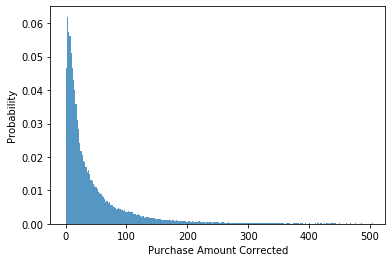

In [39]:
#sns.histplot(df_reverse['Purchase Amount'], stat="probability");
sns.histplot(df_reverse['Purchase Amount Corrected'], stat="probability");
plt.xlim(-25, 525);

#plt.savefig('figs/eda/purchase_hist_syn_ageCat70_corr.png',bbox_inches='tight')

d:\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


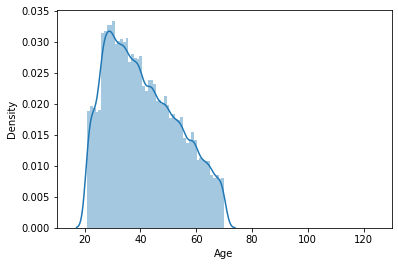

In [44]:
sns.distplot(df_reverse['Age']);
plt.xlim(10, 130);
#plt.savefig('figs/eda/age_hist_syn_ageCat70_0.5M.png',bbox_inches='tight')

In [28]:
# view counts and percentage for each column's elements
def view_column_counts(df, col_name):
    df_pivot = df.groupby(by = col_name).size().reset_index(name='Counts')
    df_pivot['Per (%)'] = (df_pivot['Counts'])/df.shape[0]*100
    df_pivot.sort_values(by = 'Counts',ascending = False,inplace = True)
    return df_pivot

In [29]:
# gender, account type, sector and retailer percentage
text_col_list = ['Account Type', 'Consumer Gender','Normalized Retailer', 'SIC Description']

for col_name in text_col_list:   
    print(col_name)
    df_pivot = view_column_counts(df_reverse,col_name)
    print(df_pivot)
    print('\n')

Account Type
   Account Type  Counts    Per (%)
0  bank_account   53597  55.243249
1   credit_card   43423  44.756751


Consumer Gender
  Consumer Gender  Counts    Per (%)
0          female   53318  54.955679
1            male   43702  45.044321


Normalized Retailer
                           Normalized Retailer  Counts   Per (%)
1339                               Tim Hortons    6326  6.520305
1433                                   Walmart    3622  3.733251
974                               Petro-Canada    3008  3.100392
797                                 McDonald's    1622  1.671820
1157                                     Shell    1585  1.633684
...                                        ...     ...       ...
766                                Make A Wish       1  0.001031
1076                  Restoration Hardware Inc       1  0.001031
1356                        Touro Churrascaria       1  0.001031
205   Cat's Caboose Dining Coach &amp; Bar Car       1  0.001031
1183            

barplot for SIC Description


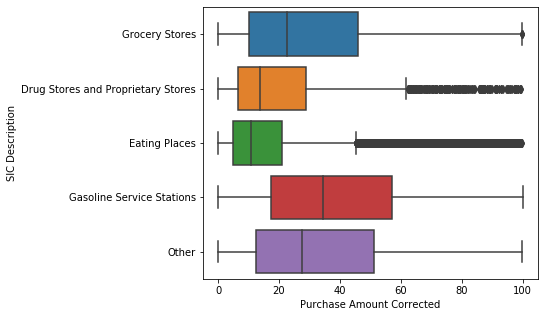

barplot for Normalized Retailer


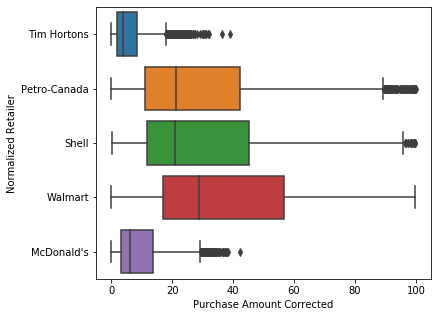

In [30]:
check_list = ['SIC Description','Normalized Retailer']
fig_dims = [6, 5] 
N = 5
threshold = 100

for cat in check_list:   
    print("barplot for %s" % (cat))
    list_tmp = df_reverse[cat].value_counts()[:N].index.tolist() # top N counts in that category
    df_tmp = df_reverse[df_reverse[cat].isin(list_tmp) & (df_reverse['Purchase Amount Corrected'] < threshold)]
    fig, ax = plt.subplots(figsize = fig_dims)
    chart = sns.boxplot(y = df_tmp[cat], x = df_tmp['Purchase Amount Corrected'])
    plt.show()